Runs a quick classifier on our cell images

In [ ]:
import DataProvider as DP
import importlib
# import  random
import numpy as np
import os
import torch
from torch.autograd import Variable



gpu_id = 0

myseed = 0
DP = importlib.reload(DP)

np.random.seed(myseed)

image_dir = '/root/data/'

opts = {}

opts['verbose'] = True
opts['pattern'] = '*.tif_flat.png'
opts['out_size'] = [64, 64]

data_path = './data_' + str(opts['out_size'][0]) + 'x' + str(opts['out_size'][1]) + '.pyt'

if os.path.exists(data_path):
    dp = torch.load(data_path)
else:

    dp = DP.DataProvider(image_dir, opts)
    torch.save(dp, data_path)

inds = [1,2]
images = dp.get_images(inds, 'train')
labels = dp.get_labels(inds, 'train')

print(images.size())
print(labels)
nlabels = dp.get_n_classes()

print('nlabels: ' + str(nlabels))



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def imshow(img):
#     img = img / 2 + 0.5 # unnormalize

    img = img.numpy()
    if img.ndim == 3:
        img = np.expand_dims(img, 0)
    img = np.transpose(img, [0,2,3,1])
    img = np.concatenate(img[:], 1)

    print(img.shape[0]*10)
    print(img.shape[1]*10)    
    fig = plt.figure(figsize = [img.shape[0]/2, img.shape[1]/2])
    

    ax = fig.add_subplot(111)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(img)
#     ax.show()
#     tight_layout()

In [ ]:
img = dp.get_images([100,1,2,3,4,5], 'train')
print(img.size())
print(np.max(img[0].numpy()))
imshow(img)

In [ ]:
from torch import nn
import torch.nn.functional as F
import pdb

nlatentdim = 2
ksize = 5
dstep = 2

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, ksize, dstep, 1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.nl1 = nn.PReLU()
        self.conv2 = nn.Conv2d(64, 128, ksize, dstep, 1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.nl2 = nn.PReLU()
        self.conv3 = nn.Conv2d(128, 256, ksize, dstep, 1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.nl3 = nn.PReLU()
        self.conv4 = nn.Conv2d(256, 512, ksize, dstep, 1)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.nl4 = nn.PReLU()
        
        self.linear5 = nn.Linear(512*3*3, nlatentdim)
        self.bn5 = nn.BatchNorm1d(nlatentdim)
        
    def forward(self, x):
        
        x = self.nl1(self.bn1(self.conv1(x)))
        x = self.nl2(self.bn2(self.conv2(x)))
        x = self.nl3(self.bn3(self.conv3(x)))
        x = self.nl4(self.bn4(self.conv4(x)))
        x = x.view(x.size()[0], 512*3*3)
        x = self.bn5(self.linear5(x))
    
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.linear1 = nn.Linear(nlatentdim, 512*3*3)
        self.bn1 = nn.BatchNorm1d(512*3*3)
        
        self.nl1 = nn.PReLU()        
        self.conv2 = nn.ConvTranspose2d(512, 256, ksize, dstep, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(256)
        
        self.nl2 = nn.PReLU()        
        self.conv3 = nn.ConvTranspose2d(256, 128, ksize, dstep, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.nl3 = nn.PReLU()        
        self.conv4 = nn.ConvTranspose2d(128, 64, ksize, dstep, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.nl4 = nn.PReLU()        
        self.conv5 = nn.ConvTranspose2d(64, 3, ksize, dstep, 1, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(3)
        self.nl5 = nn.Sigmoid()              
            
    def forward(self, x):

        x = self.bn1(self.linear1(x))
        x = x.view(x.size()[0], 512, 3, 3)

        x = self.nl1(x)
        x = self.nl2(self.bn2(self.conv2(x)))
        x = self.nl3(self.bn3(self.conv3(x)))
        x = self.nl4(self.bn4(self.conv4(x)))
        x = self.nl5(self.bn5(self.conv5(x)))
        
        return x    
    
class AdversaryZ(nn.Module):
    def __init__(self):
        super(AdversaryZ, self).__init__()
        
        nfc = 1024
        
        self.linear0 = nn.Linear(nlatentdim, nfc)
        self.bn0 = nn.BatchNorm1d(nfc)        
        self.nl0 = nn.LeakyReLU(0.2, inplace=True)       
        
        self.linear1 = nn.Linear(nfc, nfc)
        self.bn1 = nn.BatchNorm1d(nfc)
        self.nl1 = nn.LeakyReLU(0.2, inplace=True)       
        
        self.linear2 = nn.Linear(nfc, 512)
        self.bn2 = nn.BatchNorm1d(512) 
        self.nl2 = nn.LeakyReLU(0.2, inplace=True)                    
        
        self.linear3 = nn.Linear(512, 1)
#         self.bn3 = nn.BatchNorm1d(1)        
        self.nl3 = nn.Sigmoid()         
          
    def forward(self, x):
        x = self.nl0(self.linear0(x))
        x = self.nl1(self.bn1(self.linear1(x)))
        x = self.nl2(self.bn2(self.linear2(x)))
        x = self.nl3(self.linear3(x))
        
        return x        
    

encoder = Encoder()
decoder = Decoder()
adversaryZ = AdversaryZ()

encoder.apply(weights_init)
decoder.apply(weights_init)
adversaryZ.apply(weights_init)

encoder.cuda(gpu_id)
decoder.cuda(gpu_id)
adversaryZ.cuda(gpu_id)

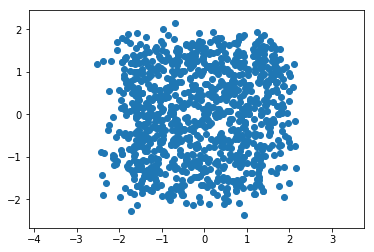

[9] loss: 0.151205 minimaxLoss: 1.427048 advLoss: 0.723860 time: 0.15
[10] loss: 0.143846 minimaxLoss: 0.700368 advLoss: 1.404914 time: 0.23
[10] loss: 0.142904 minimaxLoss: 0.727697 advLoss: 1.393649 time: 0.24
[10] loss: 0.141358 minimaxLoss: 0.685571 advLoss: 1.405849 time: 0.25
[10] loss: 0.140199 minimaxLoss: 0.731507 advLoss: 1.413272 time: 0.24
[10] loss: 0.140147 minimaxLoss: 0.717389 advLoss: 1.407474 time: 0.23
[10] loss: 0.139731 minimaxLoss: 0.736414 advLoss: 1.412628 time: 0.23
[10] loss: 0.139175 minimaxLoss: 0.712361 advLoss: 1.440768 time: 0.24
[10] loss: 0.137032 minimaxLoss: 0.803875 advLoss: 1.467911 time: 0.23


In [ ]:
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
import time

learningRate = 0.01
    
criterion = nn.BCELoss()
# optAE = optim.Adam([{'params': encoder.parameters(), 
#                     'params': decoder.parameters()}], 
#                    lr=learningRate, betas=(0.5, 0.999))

# optEnc = optim.Adam(encoder.parameters(), lr=learningRate, betas=(0.5, 0.999))
# optDec = optim.Adam(decoder.parameters(), lr=learningRate, betas=(0.5, 0.999))
# optZ = optim.Adam(adversaryZ.parameters(), lr=learningRate, betas=(0.5, 0.999))
# optZAdv = optim.Adam(encoder.parameters(), lr=learningRate, betas=(0.5, 0.999))


optEnc = optim.RMSprop(encoder.parameters(), lr=learningRate)
optDec = optim.RMSprop(decoder.parameters(), lr=learningRate)
optZ = optim.RMSprop(adversaryZ.parameters(), lr=learningRate)
optZAdv = optim.RMSprop(encoder.parameters(), lr=0.00001)




batchsize = 64
nepochs = 250

ndat = dp.get_n_train()
ndat = 1000

for epoch in range(nepochs): # loop over the dataset multiple times

    rand_inds = np.random.permutation(ndat)
    inds = (rand_inds[i:i+batchsize] for i in range(0, len(rand_inds), batchsize))
    
    zAll = list()
    
    recon_loss = 0.0
    latent_loss = 0.0
    minimax_loss = 0.0
    
    c = 0
    for i in inds:
        start = time.time()
        c += 1
        
        batsize = len(i)
        inputs = Variable(dp.get_images(i, 'train')).cuda(gpu_id)
        
#         #pick a distribution that is obvious when you plot it
        zReal = Variable(torch.Tensor(batsize, nlatentdim).uniform_(-2, 2)).cuda(gpu_id)
        yReal = Variable(torch.ones(batsize)).cuda(gpu_id)
        yFake = Variable(torch.zeros(batsize)).cuda(gpu_id)

        
        # zero the parameter gradients
        optEnc.zero_grad()
        optDec.zero_grad()
        optZ.zero_grad()
        optZAdv.zero_grad()
        
        #Autoencoder forward
        zFake = encoder(inputs)
        outputs = decoder(zFake)
        
#         #recon loss
        reconLoss = criterion(outputs, inputs)
#         reconLoss.backward()
        
#         optEnc.step()
#         optDec.step()
        
#         optEnc.zero_grad()
#         optDec.zero_grad()
#         optZ.zero_grad()
#         optZAdv.zero_grad()
        
        ###update the discriminator
        #maximize log(AdvZ(z)) + log(1 - AdvZ(Enc(x)))
        yFakeHat = adversaryZ(zFake.detach())
        errZFake = criterion(yFakeHat, yFake)
        
        yRealHat = adversaryZ(zReal.detach())
        errZReal = criterion(yRealHat, yReal)
        
        latentLoss = errZFake + errZReal
        latentLoss.backward()
        optZ.step()
        
#         optEnc.zero_grad()
#         optDec.zero_grad()
        optZ.zero_grad()
#         optZAdv.zero_grad()
        ###
        

            
        #advarsary loss
        #update: maximize log(AdvZ(Enc(x)))
#         zFake = encoder(inputs.detach())
        yFakeHat = adversaryZ(zFake)
        minimaxLoss = criterion(yFakeHat, yReal)
#         minimaxLoss.backward()

#         optZAdv.step()

        
        loss = reconLoss + minimaxLoss
        loss.backward()
        
        optEnc.step()
        optDec.step()
        
#         
        
#         minimaxLoss.backward()
#         
        
#         loss = reconLoss + minimaxLoss
        
        

        # retain some statistics
        recon_loss += reconLoss.data[0]
        minimax_loss += minimaxLoss.data[0]        
        latent_loss += latentLoss.data[0]

        zAll.append(zFake.data)
        
        stop = time.time()
        deltaT = stop-start
        
        print('[%d] loss: %.6f minimaxLoss: %.6f advLoss: %.6f time: %.2f' % (epoch+1, reconLoss.data[0], minimaxLoss.data[0] , latentLoss.data[0], deltaT))

    zAll = torch.cat(zAll,0).cpu().numpy()

    plt.gca().cla() 
    plt.scatter(zAll[:,0], zAll[:,1])
    plt.xlim([-4, 4]) 
    plt.ylim([-4, 4])     
    plt.axis('equal')
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    
    print('[%d] loss: %.6f minimaxLoss: %.6f advLoss: %.6f time: %.2f' % (epoch+1, recon_loss / c, latent_loss / c, minimax_loss /c, deltaT))
    
#     optAE.param_groups[0]['lr'] = learningRate*(0.999**epoch)
#     optAdvZ.param_groups[0]['lr'] = learningRate*(0.999**epoch)
                  
                  
print('Finished Training')

In [ ]:
import torch.optim as optim
from torch.autograd import Variable
from IPython import display

learningRate = 0.01
    
criterion = nn.BCELoss()
optAE = optim.Adam([{'params': encoder.parameters(), 
                    'params': decoder.parameters()}], 
                   lr=learningRate)

optAdvZ = optim.Adam([{'params': adversaryZ.parameters()}], 
                   lr=learningRate)

batchsize = 64
nepochs = 500

for epoch in range(nepochs): # loop over the dataset multiple times
    start = time.time()
    
    rand_inds = np.random.permutation(dp.get_n_train())
    inds = (rand_inds[i:i+batchsize] for i in range(0, len(rand_inds), batchsize))
    
    zAll = list()
    
    recon_loss = 0.0
    latent_loss = 0.0
    minimax_loss = 0.0
    
    c = 0
    for i in inds:
        c += 1
        
        batsize = len(i)
        inputs = Variable(dp.get_images(i, 'train')).cuda(gpu_id)
        
        # zero the parameter gradients
        optAE.zero_grad()
        
        #Autoencoder forward
        zFake = encoder(inputs)
        outputs = decoder(zFake)
        reconLoss = criterion(outputs, inputs)
        
        loss = reconLoss
        loss.backward()
        
        optAE.step()
        
        # retain some statistics
        recon_loss += reconLoss.data[0]
        zAll.append(zFake.data)
        
    zAll = torch.cat(zAll,0).cpu().numpy()

#     plt.gca().cla() 
#     plt.scatter(zAll[:,0], zAll[:,1])
#     plt.xlim([-4, 4]) 
#     plt.ylim([-4, 4])     
#     display.clear_output(wait=True)
#     display.display(plt.gcf()) 
    
    print('[%d] loss: %.6f advLoss: %.6f minimaxLoss: %.6f' % (epoch+1, recon_loss / c, latent_loss / c, minimax_loss /c))
    
    optAE.param_groups[0]['lr'] = learningRate*(0.999**epoch)
    optAdvZ.param_groups[0]['lr'] = learningRate*(0.999**epoch)
                  
                  
print('Finished Training')

In [ ]:
inds = range(11)
inputs = dp.get_images(inds, 'train')
               
# wrap them in Variable
inputs = Variable(inputs).cuda(gpu_id)

out = decoder(encoder(inputs))
imshow(out.data.cpu())

print(inputs.size())
print(out.size())

imshow(inputs.data.cpu())

In [ ]:
outputs.size()

In [ ]:
import torch.optim as optim
from torch.autograd import Variable

criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.Adam(net.parameters(), lr=0.0001)


batchsize = 64

gpu_id = 1
net.cuda(gpu_id)


rand_inds = np.random.permutation(dp.get_n_train())
inds = (rand_inds[i:i+batchsize] for i in range(0, len(rand_inds), batchsize))
    

In [ ]:
torch.Tensor(10, 2).uniform_(0, 2)